<a href="https://colab.research.google.com/github/park-geun-hyeong/Dacon/blob/main/Motion_keypoint/motion_keypoint_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import tqdm
import glob 

In [ ]:
path='/content/drive/MyDrive/Dacon/Motion_keypoint'

os.listdir(path)

['sample_submission.csv',
 'train_df.csv',
 'train_imgs',
 'test_imgs',
 'motion_keypoint1.ipynb',
 'motion_keypoint2.ipynb',
 'pytorch.ipynb']

##Data

In [ ]:
train = pd.read_csv(path+'/train_df.csv')
submission = pd.read_csv(path+'/sample_submission.csv')

In [ ]:
train.shape, submission.shape

((4195, 49), (1600, 49))

In [ ]:
train_img_list = sorted(glob.glob(path+'/train_imgs/*.jpg')) 
test_img_list = sorted(glob.glob(path+'/test_imgs/*jpg'))

In [ ]:
len(train_img_list),len(test_img_list)

(4195, 1600)

In [ ]:
motion_keypoint = train.iloc[:,1:].values

## Visualization

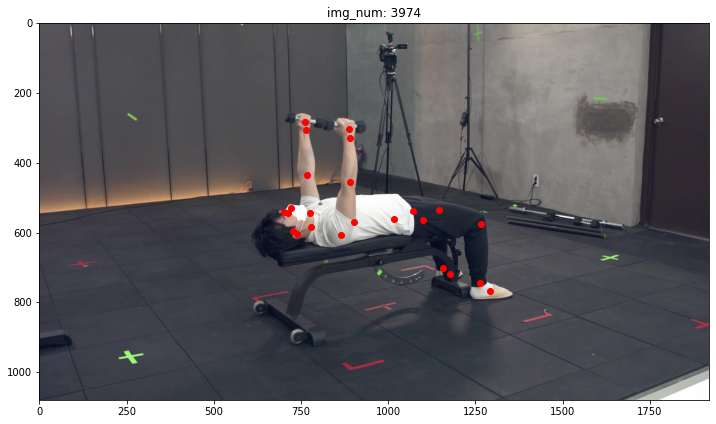

In [ ]:
a = np.random.randint(len(train_img_list))

x = motion_keypoint[a,0:49:2]
y = motion_keypoint[a,1:49:2]

img_path = train_img_list[a]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.scatter(x,y,color='r')
plt.title(f'img_num: {a}')
plt.show()

## Split Validation Data

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch import ToTensor

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

In [ ]:
x = train['image'].values
y = train.iloc[:,1:] 

In [ ]:
train['fold']=-1

In [ ]:
for i, (trn_idx,val_idx) in enumerate(kf.split(x,y)):
    train.loc[val_idx,'fold'] = i

In [ ]:
train['fold'].value_counts()

3    839
2    839
1    839
4    839
0    839
Name: fold, dtype: int64

In [ ]:
train_fold=[0,1,2,3]
val_fold = [4]

train_idx = train.loc[train.fold.isin(train_fold)].index
val_idx = train.loc[train.fold.isin(val_fold)].index

In [ ]:
len(train_idx),len(val_idx)

(3356, 839)

## DataSet, DataLoader

In [ ]:
class TrainData(Dataset):
    def __init__(self, csv, transform):
        self.csv = csv.reset_index()
        self.transform = transform
        self.img_ids = self.csv.image.values

    def __len__ (self):
        return len(self.csv)

    def __getitem__(self, index: int):
        img_id = self.img_ids[index]
        img_path = path+'/train_imgs/'+img_id
        img = cv2.imread(img_path).astype(np.uint8)

        if self.transform is not None:
            img = self.transform(image=img)['image']

        label = np.array(self.csv.iloc[index,2:-1]).astype(np.float32)

        return img, label


In [ ]:
train_transform=A.Compose([
                           ToTensor()

])

val_transform=A.Compose([
                         ToTensor()
])

In [ ]:
train_dataset = TrainData(csv = train.loc[train_idx], transform=train_transform)
val_dataset = TrainData(csv = train.loc[val_idx], transform = val_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

##Model

In [ ]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=968f17fba09c8aa212d5cbffc600426c6ce4ee13d00dec26d4301df10adae605
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [ ]:
import pretrainedmodels 
import torch.nn as nn
import torch.optim as optim

In [ ]:
model_name='resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
in_features = model.last_linear.in_features
model.last_linear = nn.Linear(in_features, 48, bias=False)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5)
loss_fn = nn.MSELoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

253

In [ ]:
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/Dacon/Motion_keypoint'

## Train

In [ ]:
model = model.to(device)
best_score = 50000

for epoch in tqdm_notebook(range(20)):
    model.train()
    train_loss=[]
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        logits = model(inputs)

        loss = loss_fn(logits, targets) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    
    val_loss=[]
    val_pred=[]
    val_true=[]

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            logits = model(inputs)

            loss = loss_fn(logits, targets)

            val_loss.append(loss.item())

            pred = np.array(logits.cpu().data)
            true = np.array(targets.cpu().data)

        val_pred.append(pred)
        val_true.append(true)

        val_pred = np.concatenate(val_pred, axis=0)
        val_true = np.concatenate(val_true, axis=0)

        final_score = mean_squared_error(val_pred, val_true)

        print(f"epoch: {epoch+1}, train_loss: {np.mean(train_loss)}, val_loss: {np.mean(val_loss)}, score: {final_score}")

        if final_score < best_score:
            best_score = final_score

            state_dict = model.cpu().state_dict()
            model = model.to(device)

            torch.save(state_dict, 'keypoint_model.pt') 


In [ ]:
model.load_state_dict(torch.load(path+'/keypoint_model.pt'))

<All keys matched successfully>

## TestDataset, TestDataLoader

In [ ]:
class TestData(Dataset):
    def __init__(self, csv, transform):
        self.csv = csv.reset_index()
        self.transform = transform
        self.img_ids = self.csv.image.values

    def __len__ (self):
        return len(self.csv)

    def __getitem__(self, index: int):
        img_id = self.img_ids[index]
        img_path = path+'/test_imgs/'+img_id
        img = cv2.imread(img_path).astype(np.uint8)

        if self.transform is not None:
            img = self.transform(image=img)['image']

    
        return img


In [ ]:
test_transform = A.Compose([
                            
                            ToTensor()
])

In [ ]:
test_dataset = TestData(csv = submission, transform = test_transform)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle=False, num_workers=2)

## Prediction

In [ ]:
preds=[]

model.eval()
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)

        logits = model(inputs)

        pred = np.array(logits.cpu().data)
        preds.append(logits)

In [ ]:
from tqdm import tqdm

In [ ]:
preds_cpu=[]

for i in tqdm(range(len(preds))):
    new_pred = preds[i].cpu().data
    preds_cpu.append(new_pred)


100%|██████████| 200/200 [00:00<00:00, 20159.59it/s]


In [ ]:
new_preds = np.concatenate(preds_cpu, axis=0)

In [ ]:
 submission.iloc[:,1:] = new_preds

In [ ]:
os.chdir('/content')

In [ ]:
submission.to_csv('motion_detection.csv',index=False)